# Spectral Clustering for Image Segmentation

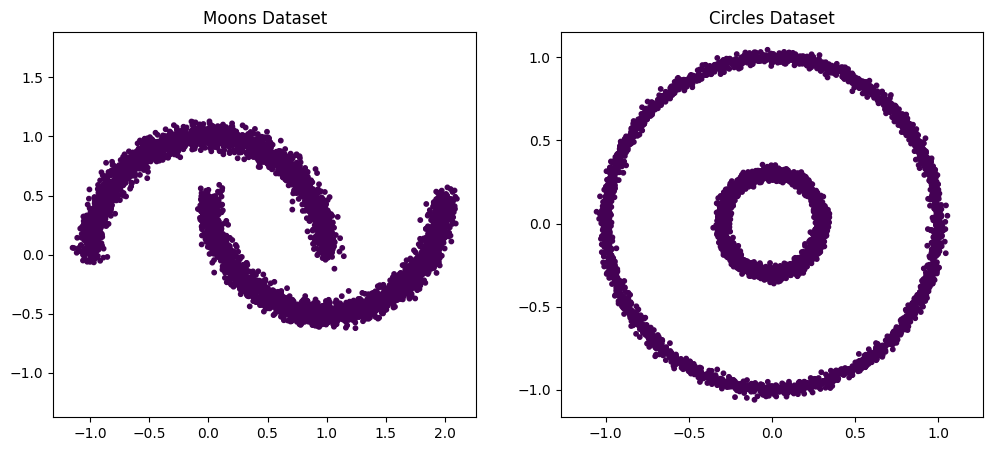

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles, make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import kneighbors_graph
from scipy import sparse
from scipy.sparse.linalg import eigsh
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import StandardScaler

n_samples = 5000
random_state = 42


X_moons, y_moons = make_moons(n_samples=n_samples, noise=0.05, random_state=random_state)
X_circles, y_circles = make_circles(n_samples=n_samples, factor=0.3, noise=0.02, random_state=random_state)

def plot_clusters(X, labels, title):
    plt.scatter(X[:, 0], X[:, 1], c=labels, s=10, cmap='viridis')
    plt.title(title)
    plt.axis('equal')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1); plot_clusters(X_moons, np.zeros(n_samples), "Moons Dataset")
plt.subplot(1, 2, 2); plot_clusters(X_circles, np.zeros(n_samples), "Circles Dataset")
plt.show()

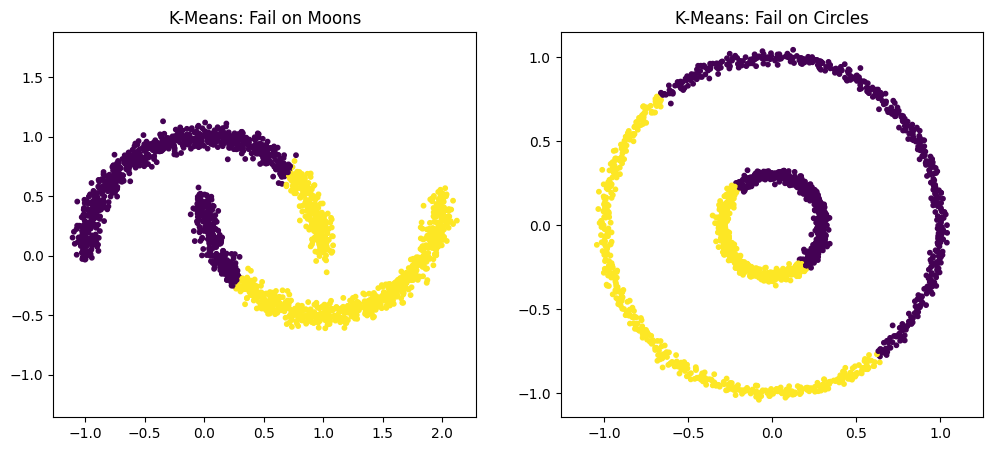

In [10]:
kmeans_moons = KMeans(n_clusters=2, random_state=random_state).fit(X_moons)
kmeans_circles = KMeans(n_clusters=2, random_state=random_state).fit(X_circles)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons, kmeans_moons.labels_, "K-Means: Fail on Moons")
plt.subplot(1, 2, 2)
plot_clusters(X_circles, kmeans_circles.labels_, "K-Means: Fail on Circles")
plt.show()

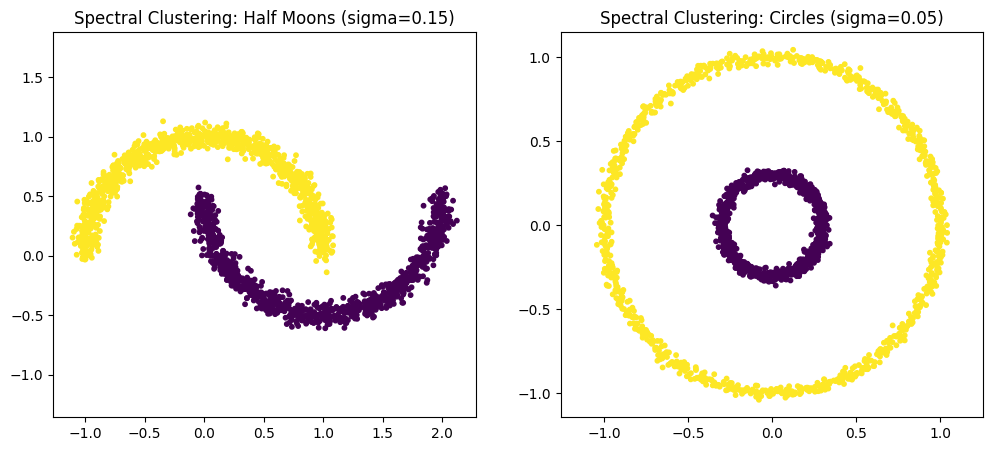

In [11]:
def spectral_clustering_dense(X, n_clusters, sigma=0.5):
    N = X.shape[0]
    
    dists = pairwise_distances(X, metric='euclidean')
    W = np.exp(- (dists ** 2) / (2 * sigma ** 2))
    np.fill_diagonal(W, 0) # Rimuoviamo self-loops
    
    d = np.sum(W, axis=1)
    d_inv_sqrt = np.power(d, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    
    I = np.eye(N)
    L_sym = I - D_inv_sqrt @ W @ D_inv_sqrt

    eigenvals, eigenvecs = np.linalg.eigh(L_sym)
    U = eigenvecs[:, :n_clusters]
    
    rows_norm = np.linalg.norm(U, axis=1, keepdims=True)
    rows_norm[rows_norm == 0] = 1 
    U_normalized = U / rows_norm
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(U_normalized)
    
    return labels


labels_sc_moons = spectral_clustering_dense(X_moons, n_clusters=2, sigma=0.15)
labels_sc_circles = spectral_clustering_dense(X_circles, n_clusters=2, sigma=0.05)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plot_clusters(X_moons, labels_sc_moons, "Spectral Clustering: Half Moons (sigma=0.15)")

plt.subplot(1, 2, 2)
plot_clusters(X_circles, labels_sc_circles, "Spectral Clustering: Circles (sigma=0.05)")

plt.show()

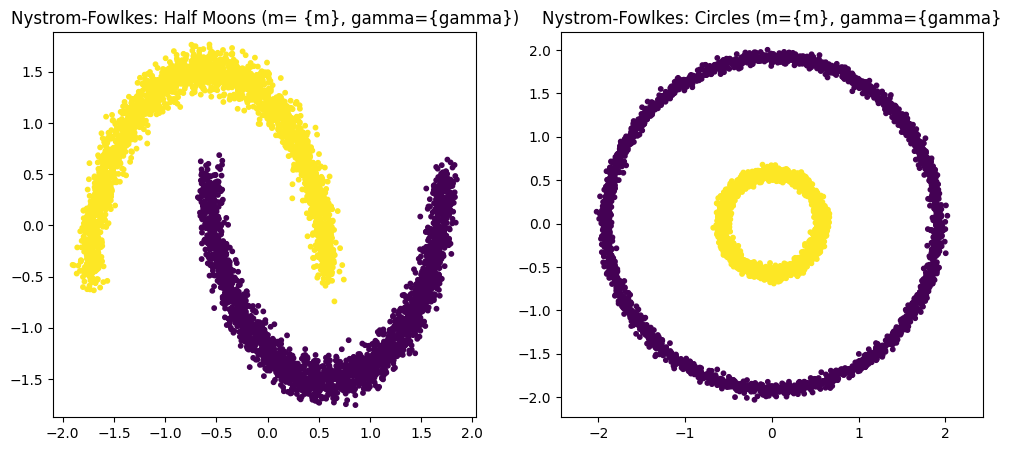

In [ ]:
def nystrom_fowlkes_spectra_clustering(X, m, n_clusters, gamma=None):
    n = X.shape[0]
    if gamma is None:
        gamma = 1.0 / (2 * np.median(np.var(X, axis=0)))

    
    indices = np.random.choice(n, m, replace=False)
    mask = np.zeros(n, dtype=bool)
    mask[indices] = True
    
    X_sampled = X[mask]
    X_remaining = X[~mask]
    
    
    A = rbf_kernel(X_sampled, X_sampled, gamma=gamma)
    B = rbf_kernel(X_remaining, X_sampled, gamma=gamma)

#-------ROBA CHE DEVO CANCORA CAPIRE BENE--------
    # 3. NORMALIZZAZIONE LAPLACIANA (Il pezzo mancante)
    # Calcolo del grado d (somma delle righe della matrice di affinità completa)
    d = np.concatenate([
        np.sum(A, axis=1) + np.sum(B.T, axis=1),
        np.sum(B, axis=1) + B @ (np.linalg.pinv(A) @ np.sum(B.T, axis=1))
    ])
    d_inv_sqrt = 1.0 / np.sqrt(d + 1e-10)
    
    # Normalizziamo A e B per riflettere la Laplaciana: K_norm = D^-1/2 K D^-1/2
    # Estraiamo i pezzi di D^-1/2
    d_m = d_inv_sqrt[:m]
    d_nm = d_inv_sqrt[m:]
    
    A_norm = np.diag(d_m) @ A @ np.diag(d_m)
    B_norm = np.diag(d_nm) @ B @ np.diag(d_m)

#FINO A QUI---------------------------------

    # 4. Decomposizione di A_norm A = U V U'
    v_eigenvals, U = np.linalg.eigh(A_norm)
    v_eigenvals = np.maximum(v_eigenvals[::-1], 1e-10)
    U = U[:, ::-1]

    # A^(-1/2)
    A_inv_sqrt = U @ np.diag(1.0 / np.sqrt(v_eigenvals)) @ U.T

    # 5. Decomposizione Q ; Q = A_norm + A^(-1/2) B_norm' B_norm A^(-1/2)
    Q = A_norm + A_inv_sqrt @ (B_norm.T @ B_norm) @ A_inv_sqrt
    v_q, U_q = np.linalg.eigh(Q)
    v_q = np.maximum(v_q[::-1], 1e-10)
    U_q = U_q[:, ::-1]

    
    combined_AB_norm = np.zeros((n, m))
    combined_AB_norm[mask] = A_norm
    combined_AB_norm[~mask] = B_norm
    
    V_final = combined_AB_norm @ A_inv_sqrt @ U_q @ np.diag(1.0 / np.sqrt(v_q))

    
    V_k = V_final[:, :n_clusters] 
    
    
    row_norms = np.linalg.norm(V_k, axis=1, keepdims=True)
    V_normalized = V_k / (row_norms + 1e-10)

    return KMeans(n_clusters=n_clusters, n_init=10).fit_predict(V_normalized)

scaler = StandardScaler()
X_moons_scaled = scaler.fit_transform(X_moons)
X_circles_scaled = scaler.fit_transform(X_circles)

labels_nystrom_moons = nystrom_fowlkes_spectra_clustering(X_moons_scaled, m=150, n_clusters=2, gamma=10.0)
labels_nystrom_circles = nystrom_fowlkes_spectra_clustering(X_circles_scaled, m=150, n_clusters=2, gamma=2.0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_clusters(X_moons_scaled, labels_nystrom_moons, "Nystrom-Fowlkes: Half Moons (m= {m}, gamma={gamma})")
plt.subplot(1, 2, 2)
plot_clusters(X_circles_scaled, labels_nystrom_circles, "Nystrom-Fowlkes: Circles (m={m}, gamma={gamma}")

In [ ]:
#CELLA VELOCE PER VEDERE TEMPO E PRECISIONE

import time
from sklearn.cluster import SpectralClustering
from sklearn.metrics import adjusted_rand_score

# Parametri
m_points = 150
gamma_test = 2.0

print(f"Esecuzione test su {X_circles_scaled.shape[0]} punti...")

# --- 1. Test Nyström-Fowlkes ---
start = time.time()
labels_nyst = nystrom_fowlkes_spectra_clustering(X_circles_scaled, m=m_points, n_clusters=2, gamma=gamma_test)
time_nyst = time.time() - start
ari_nyst = adjusted_rand_score(y_circles, labels_nyst)

# --- 2. Test Spectral Clustering Standard ---
start = time.time()
sc = SpectralClustering(n_clusters=2, gamma=gamma_test, affinity='rbf', eigen_solver='arpack')
labels_std = sc.fit_predict(X_circles_scaled)
time_std = time.time() - start
ari_std = adjusted_rand_score(y_circles, labels_std)

# --- Print Risultati ---
print("-" * 40)
print(f"{'METODO':<20} | {'TEMPO':<10} | {'PRECISIONE (ARI)':<15}")
print("-" * 40)
print(f"{'Nyström-Fowlkes':<20} | {time_nyst:.4f}s | {ari_nyst:.4f}")
print(f"{'Standard Spectral':<20} | {time_std:.4f}s | {ari_std:.4f}")
print("-" * 40)
print(f"🚀 Speedup: {time_std / time_nyst:.2f}x più veloce")
print(f"📊 Delta Precisione: {abs(ari_std - ari_nyst):.4f}")

Esecuzione test su 2000 punti...
----------------------------------------
METODO               | TEMPO      | PRECISIONE (ARI)
----------------------------------------
Nyström-Fowlkes      | 0.3540s | 1.0000
Standard Spectral    | 1.2069s | 1.0000
----------------------------------------
🚀 Speedup: 3.41x più veloce
📊 Delta Precisione: 0.0000
